# Training Logistic Regression via Stochastic Gradient Ascent

In [1]:
import pandas as pd

In [2]:
products = pd.read_csv('data/amazon_baby_subset.csv')

In [6]:
important_words = pd.read_json('data/important_words.json')[0].tolist()

In [8]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [10]:
def remove_punctuation(text):
    import string
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

In [11]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [12]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

/tmp/ipykernel_2312/1263213523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
/tmp/ipykernel_2312/1263213523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  products[word] = products['review_clean'].apply(lambda s : s.split().count(word))
/tmp/ipykernel_2312/1263213523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [13]:
train_idx = pd.read_json('data/module-10-assignment-train-idx.json')
validation_idx = pd.read_json('data/module-10-assignment-validation-idx.json')

In [29]:
train_data = products.iloc[train_idx[0].tolist()].reset_index(drop=True)
validation_data = products.iloc[validation_idx[0].tolist()].reset_index(drop=True)


In [30]:
train_data

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47775,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,My infant goes to a really crappy daycare and ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47776,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,Pretty please open and inspect these stickers ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47777,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,Great 5Star Product but An Obvious knockoff of...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47778,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,When I received the item my initial thought wa...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [32]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

In [33]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

In [34]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    # Return the derivative
    return derivative

In [35]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

## Modifying the derivative for stochastic gradient ascent
We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

In [37]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


## Modifying the derivative for using a batch of data points

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

In [39]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")


Gradient mini-batch data points: 1.0
                --> Should print 1.0


### Averaging the gradient across a batch
It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Complete the following function to fit a logistic regression model using gradient ascent:

In [63]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    B = batch_size
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]

        predictions = predict_probability(feature_matrix[i:i+B,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]

        indicator = (sentiment[i:i+B]==+1).astype(int)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]

            derivative = feature_derivative(errors, feature_matrix[i:i+B,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            
            coefficients[j] += step_size*derivative/B
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [64]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print('-------------------------------------------------------------------------------------')
print('Coefficients learned                 :', coefficients)
print('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3) and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print('-------------------------------------------------------------------------------------')
    print('Test passed!')
else:
    print('-------------------------------------------------------------------------------------')
    print('Test failed')

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


In [65]:
initial_coefficients = np.zeros(194)

step_size = 5e-1

batch_size = 1

max_iter = 10

In [79]:
len(feature_matrix_train)

47780

In [ ]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=step_size, batch_size=batch_size, max_iter=max_iter)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


In [67]:
initial_coefficients = np.zeros(194)

step_size = 5e-1

batch_size = feature_matrix_train.shape[0]

max_iter = 200

In [68]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=step_size, batch_size=batch_size, max_iter=max_iter)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

In [69]:
step_size=1e-1
num_passes = 10
batch_size=100
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
initial_coefficients = np.zeros(194)
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

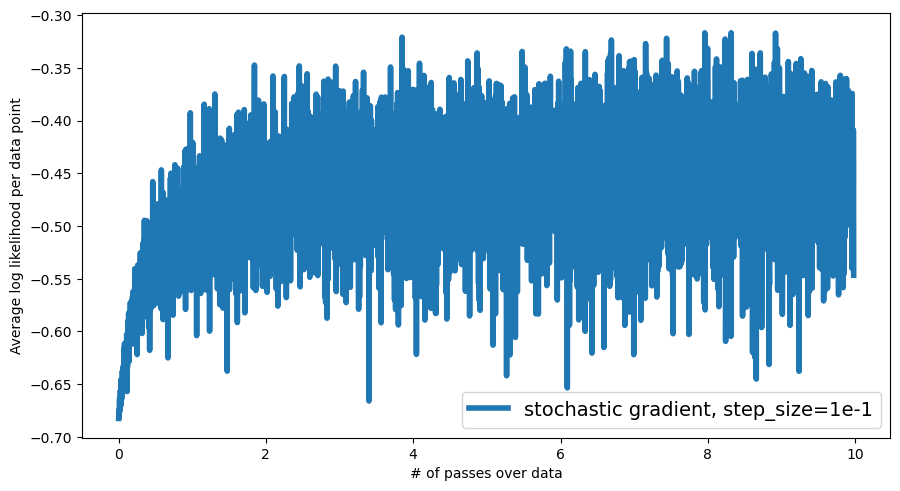

In [ ]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [72]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
oefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

In [74]:
step_size = 0.5
batch_size = len(feature_matrix_train)
num_iterations = 200
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

/tmp/ipykernel_2312/64643201.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


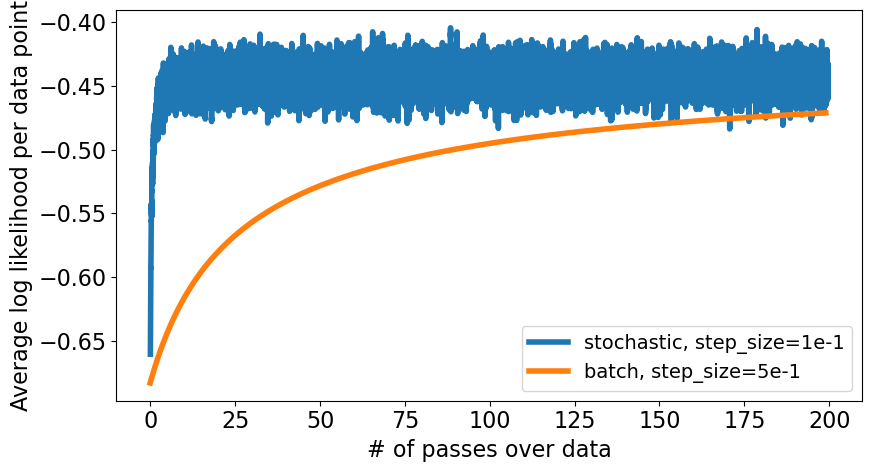

In [75]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

## Explore the effects of step sizes on stochastic gradient ascent

In [76]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

/tmp/ipykernel_2312/2211151483.py:5: RuntimeWarning: overflow encountered in exp
  logexp = np.log(1. + np.exp(-scores))
/tmp/ipykernel_2312/1930161331.py:6: RuntimeWarning: overflow encountered in exp
  predictions = 1. / (1.+np.exp(-score))


Iteration  100: Average log likelihood (of data points in batch [10000:10100]) = -10.64501704
Iteration  200: Average log likelihood (of data points in batch [20000:20100]) = -4.03716668
Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -6.27537099
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -5.84903743
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -15.17802364
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -25.24883217
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -8.58194443
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -4.38550348
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -4.01454620
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -4.12845699
Iteration 2000: Average log likelihood (of data points in batch [09

### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

/tmp/ipykernel_2312/64643201.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


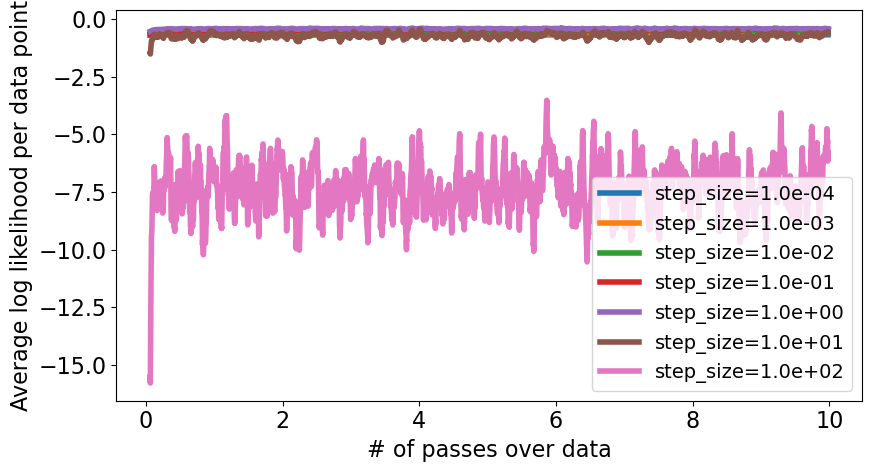

In [77]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

/tmp/ipykernel_2312/64643201.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


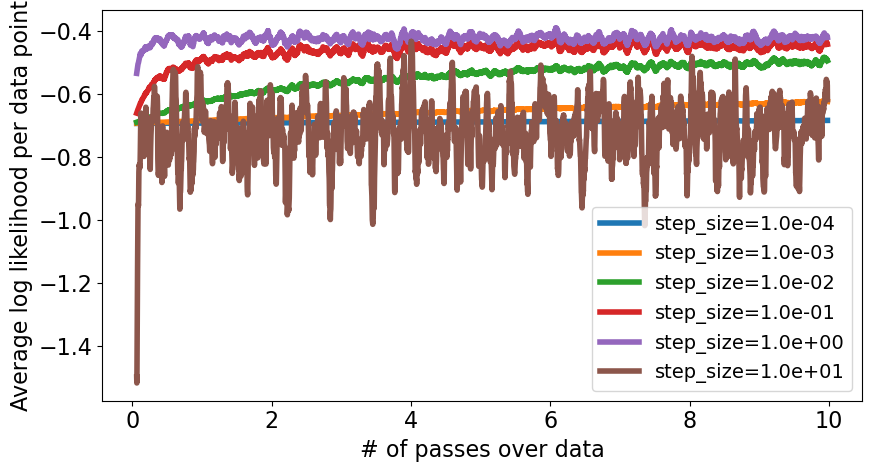

In [78]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)